# Exercise 5

## Helper functions

In [1]:
import numpy as np
import cv2 
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib

def load_im(path : str, greyscale : bool = False) -> np.ndarray:
    """
        Takes:
            :param path: Path to where the image should be loaded
            :param greyscale: A flag that determines whether the image should be loaded as greyscale or not
            
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    if greyscale:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    return im


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom


def hest(q1, q2) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x)) # <-- formula follows that of week 2, slide 56
        # print(np.kron(q2t_hom.T, q1x).shape)
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    
def crossOp(p : np.ndarray) -> np.ndarray:
    """
        One of Them weird functions. It takes in a 3D vector and then returns
        some gnarly matrix.
    """
    p = p.flatten()
    if p.size != 3:
        raise Exception("Invalid input, vector must be exactly 3D.")
    
    x, y, z = p
    px = np.array(
        [[0, -z, y],
         [z, 0, -x],
         [-y, x, 0]]
    )
    
    return px


def computeFundamentalMatrix(K1 : np.ndarray, K2 : np.ndarray, R2 : np.ndarray, t2 : np.ndarray) -> np.ndarray:
    """
        Computing the fundamental matrix between two camera matrices K1 & K2.
    """
    t2x = crossOp(t2)

    E = t2x @ R2

    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)

    F = K1inv.T @ E @ K2inv
    
    return F


def fancyRotate(theta_x, theta_y, theta_z):
    """
        Does the rotation matrix that we have seen a few times.
        E.g. Exercises week 4, eq(12).
    """
    from scipy.spatial.transform import Rotation
    
    R = Rotation.from_euler("xyz", [theta_x, theta_y, theta_z]).as_matrix()
    
    return R


def triangulate(q_thicc : list, P_thicc : list):
    """
        Should take in:
            A list of n pixel-coordinates: [q1, q2, ..., qn]
            
            A list of n projection matrices: [P1, P2, ..., Pn]
        
        And return:
            The triangulation of the 3D point by utilizing the linear algorithm.
    """
    
    n = len(P_thicc)
    m = P_thicc[0].shape[1]
    
    B = np.zeros((2*n, m))
    
    for i in range(n):
        Pi = P_thicc[i]
        x, y = q_thicc[i]
        x, y = x.item(), y.item()   # <-- apparently there could be some issues with indexing of arrays
        
        B[i*2] = Pi[2] * x - Pi[0]
        B[i * 2 + 1] = Pi[2] * y - Pi[1]
        
    u, s, vh = np.linalg.svd(B)
    v = vh.T
    Q = v[:, -1]
    
    Q = Q.T / Q[-1] # <-- This scaling was highly recommended by Andreas <3
    
    return Q

def RMSE(q : np.ndarray, q_tilde : np.ndarray) -> np.ndarray:
    m = q.shape[1]
    reproject_err = np.sqrt(np.sum(np.power(q_tilde - q, 2)) / m)
    return reproject_err



## Initial setup
Its propaply good to remember that:
$$
    \begin{align*}
        \pmb{p}_h &= \pmb{K} \pmb{P}_{cam}
        \\
        &=  \pmb{K} \left[ \pmb{R} \pmb{t} \right] \pmb{P}_h
    \end{align*}
$$

Where:
$$
    \begin{equation*}
        \mathcal{P} = \pmb{K} \left[ \pmb{R} \pmb{t} \right]
    \end{equation*}
$$

As per usual we have some rotations and translations. They are defined as follows:

$$
    \begin{gather*}
        \pmb{R}_1 = \pmb{R}_2 = \pmb{I},
    \end{gather*}
$$

$$
    \begin{align*}
        \pmb{t}_1 &=
        \begin{bmatrix}
            0 & 0 & 1
        \end{bmatrix}^T
        \\
        \pmb{t}_2 &=
        \begin{bmatrix}
            0 & 0 & 20
        \end{bmatrix}^T
    \end{align*}
$$

$$
    \begin{gather*}
        \pmb{K}_1 = \pmb{K}_2 = 
        \begin{bmatrix}
            700 & 0     & 600 \\
            0   & 700   & 400 \\
            0   & 0     & 1
        \end{bmatrix}.
    \end{gather*}
$$

Where both cameras observe the point:
$$
    \begin{gather*}
        \pmb{Q} = 
        \begin{bmatrix}
            1 & 1 & 0
        \end{bmatrix}^T.
    \end{gather*}
$$

In [2]:
import copy

R1 = np.eye(3)
R2 = copy.deepcopy(R1)

t1 = np.array([0, 0, 1]).reshape(-1, 1)
t2 = np.array([0, 0, 20]).reshape(-1, 1)

K1 = np.array(
    [[700,  0,      600],
     [0,    700,    400],
     [0,    0,      1]]
)

K2 = copy.deepcopy(K1)

Q = np.array([1, 1, 0]).reshape(-1, 1)

## Ex. 5.1

What are the projectiopn matrices $\pmb{P}_1$ and $\pmb{P}_2$?

What is the projection of $\pmb{Q}$ in cameras one and two ($\pmb{q}_1$ and $\pmb{q}_2$)?


### Response

In [3]:
Rt1 = np.concatenate((R1, t1), axis=1)
Rt2 = np.concatenate((R2, t2), axis=1)


P1 = K1 @ Rt1
P2 = K2 @ Rt2

qs1 = projectPoints(K1, Rt1, Q)
qs2 = projectPoints(K2, Rt2, Q)

print(f"Yields projection matrices: \nP1\n{P1} \nP2\n{P2}\n")
print(f"\nand the projected points: \nqs1\n{qs1} \nqs2\n{qs2}\n")

Yields projection matrices: 
P1
[[700.   0. 600. 600.]
 [  0. 700. 400. 400.]
 [  0.   0.   1.   1.]] 
P2
[[7.0e+02 0.0e+00 6.0e+02 1.2e+04]
 [0.0e+00 7.0e+02 4.0e+02 8.0e+03]
 [0.0e+00 0.0e+00 1.0e+00 2.0e+01]]


and the projected points: 
qs1
[[1300.]
 [1100.]] 
qs2
[[635.]
 [435.]]



## Ex. 5.2

To simulate noise in the detection of points, we add errors to our projections.

$$
    \tilde{\pmb{q}}_1 = \pmb{q}_1 + [1 - 1]^T, \quad
    \tilde{\pmb{q}}_2 = \pmb{q}_2 + [1 - 1]^T. 
$$

Use your function `triangulate` from week 3 to triangulate $\pmb{Q}$ from $[\tilde{\pmb{q}}_1, \tilde{\pmb{q}}_2]$ and $[\pmb{P}_1, \pmb{P}_2]$.

Take the newly triangulated point $\tilde{\pmb{Q}}$ and re-project it to the cameras. How far is it from our observations of the point ($\tilde{\pmb{q}_1}, \tilde{\pmb{q}_2}$)? In other words, what is the repojection error for each camera?

Is this as you expected when recalling the lecture from week?

How far is $\tilde{\pmb{Q}}$ from $\pmb{Q}$?

### Response

In [4]:
error = np.array([[1,-1]]).T
q1_tilde = qs1 + error
q2_tilde = qs2 + error
Q_tilde = pi(triangulate([q1_tilde, q2_tilde], [P1, P2])).reshape(-1, 1)

print(f"Q_tilde: \n{Q_tilde}\n")

q1_appr = projectPoints(K1, Rt1, Q_tilde)
q2_appr = projectPoints(K2, Rt2, Q_tilde)

# what are the coordinates of the projected points
print(f"q1_approx: \n{q1_appr}\n")
print(f"q2_approx: \n{q2_appr}\n")

Q_tilde: 
[[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]

q1_approx: 
[[1310.48950027]
 [1089.4923513 ]]

q2_approx: 
[[635.53411968]
 [434.4839772 ]]



In [5]:

print(f"Q: \n{Q}\n")
print(f"Q_tilde: \n{Q_tilde}\n")

# reprojection error
print(f"Alex says that the reprojection error in this case, \nis just the norm of the difference between the two points.")
print(f"Reprojection Error (q1_tilde, q1_approx): {np.linalg.norm((q1_tilde - q1_appr), 2)}")
print(f"Reprojection Error (q2_tilde, q2_approx): {np.linalg.norm((q2_tilde - q2_appr), 2)}")
print(f"Reprojection Error (Q_tilde, Q): {np.linalg.norm(Q - Q_tilde)}")


Q: 
[[1]
 [1]
 [0]]

Q_tilde: 
[[1.01527507e+00]
 [9.85270570e-01]
 [2.85786810e-04]]

Alex says that the reprojection error in this case, 
is just the norm of the difference between the two points.
Reprojection Error (q1_tilde, q1_approx): 13.43301898819186
Reprojection Error (q2_tilde, q2_approx): 0.6717725840473775
Reprojection Error (Q_tilde, Q): 0.02122181735338073


## Ex. 5.3

We are going to make a new function `triangulate_nonlin` that does triangulation using nonlinear optimization. It should take the same inputs as `triangulate`, i.e. a list of *n* pixel coordinates (`q1`, `q2`, . . . , `qn`), and a list of *n* projection matrices (`P1`, `P2`, . . . , `Pn`).

Start by defining a helper-function inside `triangulate_nonlin`.

(*Don't do that, that's wack. Put the helper function someplace else*).


This function, called `compute_residuals`, should take the parameters we want to optimize (in this case $\pmb{Q}$) as input, and should returns a vector of residuals (i.e. the numbers that we want to minimize the sum of squares of). In this case the residuals are the differences in projection, i.e

$$
    \begin{bmatrix}
        \Pi(\pmb{P}_1 \pmb{Q}_h) - \tilde{\pmb{q}}_1
        \\
        \Pi(\pmb{P}_2 \pmb{Q}_h) - \tilde{\pmb{q}}_2
        \\
        \vdots
        \\
        \Pi(\pmb{P}_n \pmb{Q}_h) - \tilde{\pmb{q}}_n
    \end{bmatrix}
$$

Call `triangulate` inside your function to get an initial guess `x0` and use `scipy.optimize.least_squares(compute_residuals, x0)` to do least squares optimization, starting from the initial guess of your linear algorithm.

### Response

In [6]:
if False: # <-- Best way to uncomment something
    def compute_residuals(x, qs : list, Ps : list) -> np.ndarray:
        """
            objective function
        """
        out = np.concatenate([pi(p @ x) - q.ravel() for p, q in zip(Ps, qs)])
        return out
    
    
def triangulate_nonlin(qs : list, Ps : list):
    """
        triangulate points from multiple cameras using non-linear optimization
    """
        
    x0 = triangulate(qs, Ps)
    
    def compute_residuals(x):
        """
            objective function
        """
        out = np.concatenate([pi(p @ x) - q.ravel() for p, q in zip(Ps, qs)])
        return out
    
    # Amazing one-liner from Andreas
    #compute_residuals = lambda x, qs, Ps: np.concatenate([pi(p @ x) - q.ravel() for p, q in zip(Ps, qs)])
    x = scipy.optimize.least_squares(compute_residuals, x0).x
    
    return x

Q_hat = pi(triangulate_nonlin([q1_tilde, q2_tilde], [P1, P2])).reshape(-1, 1)
print(f"Q_hat (inhom): \n{Q_hat}\n")

Q_hat (inhom): 
[[1.00153898e+00]
 [9.98546325e-01]
 [4.27526290e-05]]



## Ex. 5.4

Use `triangulate_nonlin` with $[\tilde{\pmb{q}}_1, \tilde{\pmb{q}}_2]$ and $[\pmb{P}_1, \pmb{P}_2]$.

Let us call the nonlinearly estimated point $\tilde{\pmb{Q}}$.

What is the reprojection error of $\hat{\pmb{Q}}$ to camera 1 and 2?

How far is $\hat{\pmb{Q}}$ from $\pmb{Q}$.

Is this an improvement over the results in *Exercise 5.2*?

Congratulations! You now have a useful function that does not currently exist in OpenCV!


### Response

In [7]:
print(f"Error with non-linear optimization: \n{np.linalg.norm(Q - Q_hat)}")

Error with non-linear optimization: 
0.0021174155384269767


In [8]:
q1_appr2 = projectPoints(K1, Rt1, Q_hat)
q2_appr2 = projectPoints(K2, Rt2, Q_hat)

# what are the coordinates of the projected points
print(f"q1_approx_2: \n{q1_appr2}\n")
print(f"q2_approx_2: \n{q2_appr2}\n")

q1_approx_2: 
[[1301.04731242]
 [1098.95254569]]

q2_approx_2: 
[[635.05378927]
 [434.94904668]]



Very good..
Yes way better!

In [9]:
print(f"Reprojection Error (q1_tilde, q1_approx_2): {np.linalg.norm((q1_tilde - q1_appr2), 2)}")
print(f"Reprojection Error (q2_tilde, q2_approx_2): {np.linalg.norm((q2_tilde - q2_appr2), 2)}")

Reprojection Error (q1_tilde, q1_approx_2): 0.06701027274072648
Reprojection Error (q2_tilde, q2_approx_2): 1.3401508667025752


# Camera calibration with OpenCV

In the following exercises you will be calibrating your own camera. For this we suggest using a camera in your phone or similar.

If you have a phone with a wide angle camera, consider using this camera for the exercise (as more lens distortion is more fun and challenging). Remember to disable lens correction in your camera app before taking the pictures.

If you get stuck with the OpenCV functions, start by looking it up in the [OpenCV documentation](https://docs.opencv.org/4.x/).

## Ex. 5.5

Take one of the provided calibration targets or print your own. If you do not have access to a printer, showing the target on a laptop or tablet display is also an option, albeit less ideal due to the glass on top of the display, which can cause reflection and refraction.

Using your calibration target, take pictures of it from many different angles. Make sure to have an image of it straight on and well lit, and try more extreme angles as well. Try to get every part of the frame covered. You should have around **twenty** (20) **images**.

Be aware that most phones rotate the image to make it appear correctly on a computer (portrait or landscape). Therefore, try to hold the phone so it rotates all images in the same way during capture.

### Response

Showing me images!

Done loading images... now plotting!


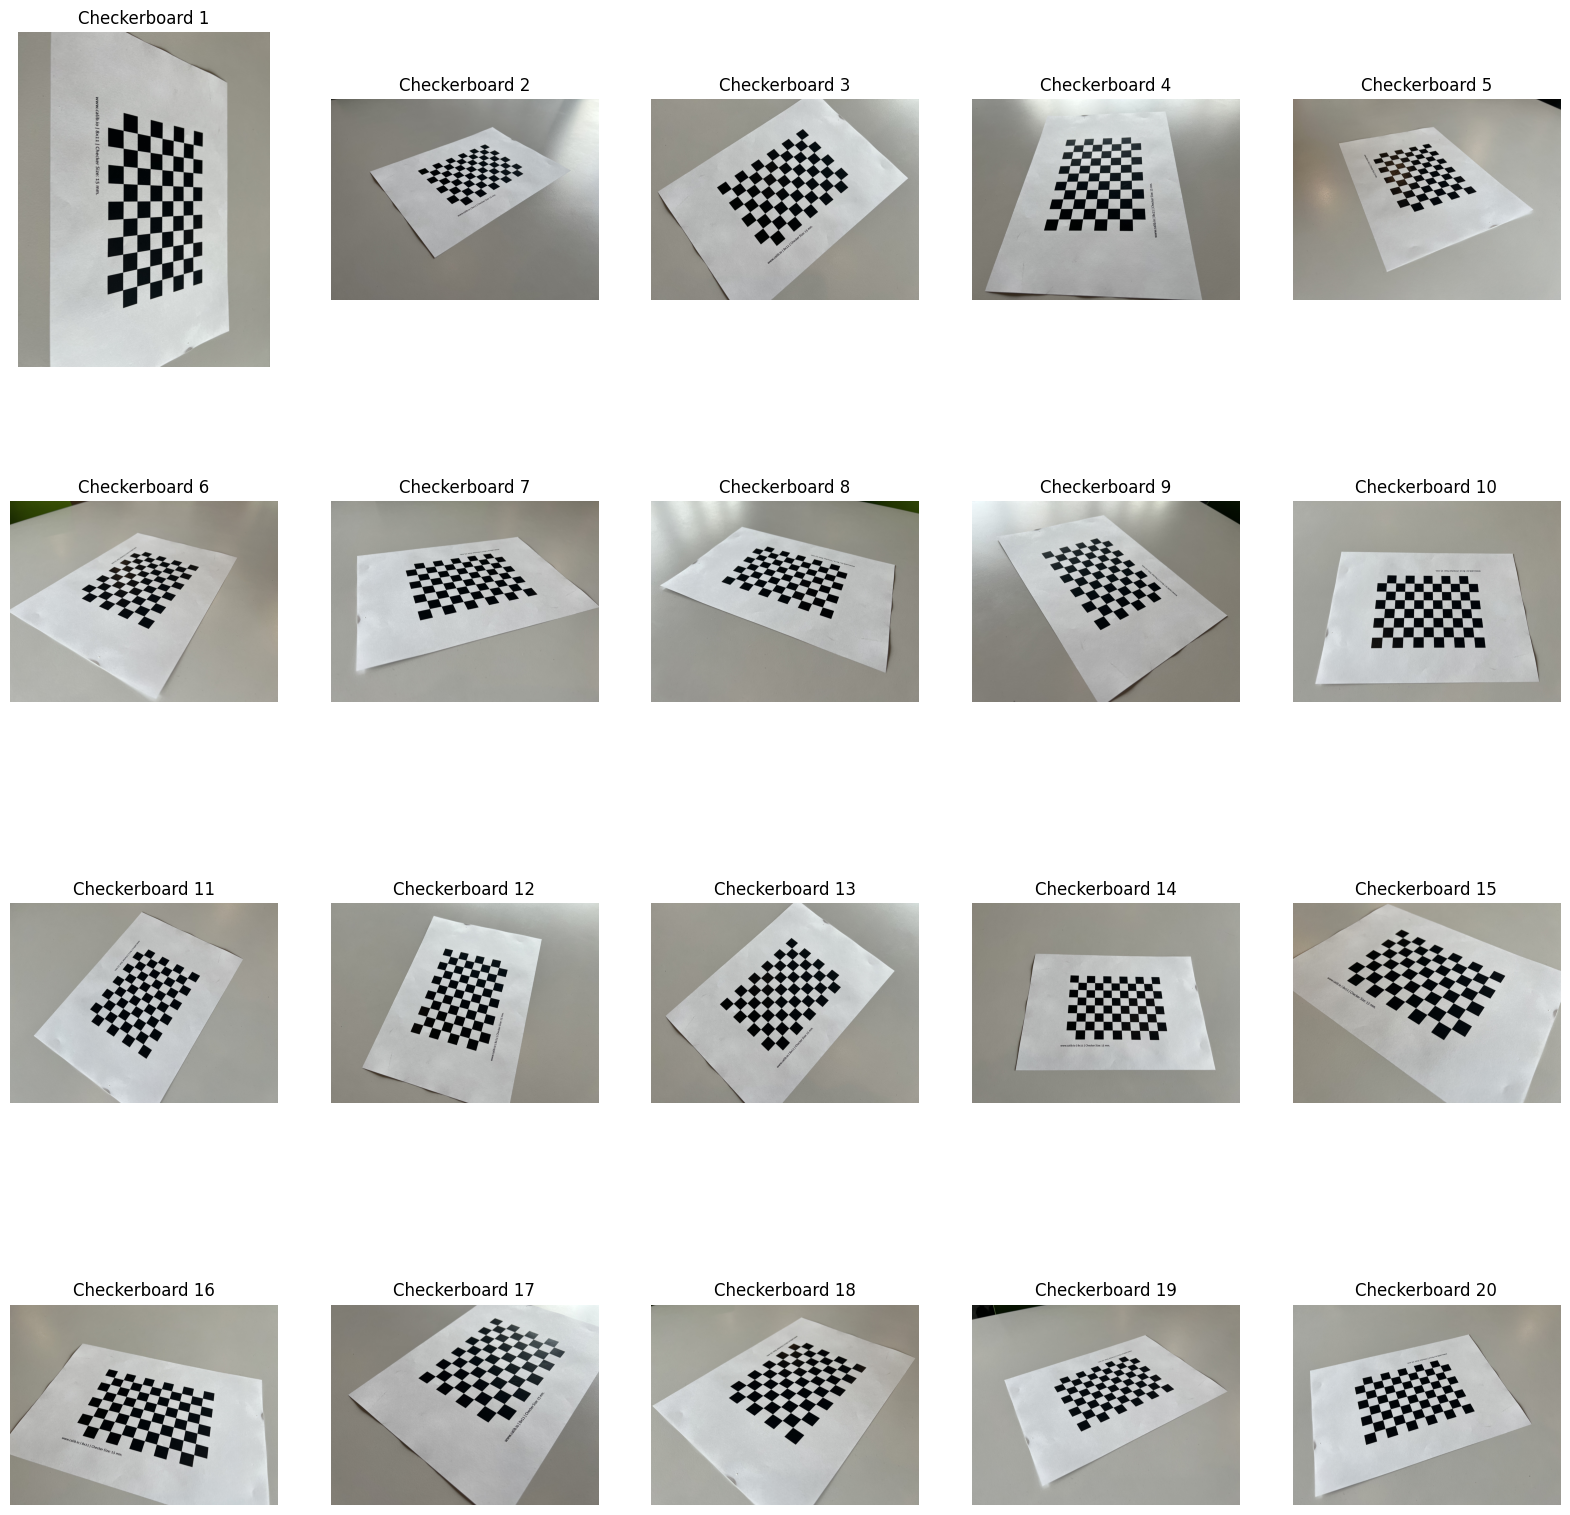

In [11]:
CHECKERBOARD_PATH = "../Data/Week_05/"

NUM_IMS = 20
ims = [None] * NUM_IMS

# We know that there is exacly 20 images in this folder
# That is why we do a subplot of 4 x 5
plt.figure(figsize=(20, 20))
for i, filename in enumerate(os.listdir(CHECKERBOARD_PATH)):
    im = load_im(CHECKERBOARD_PATH + filename)
    ims[i] = im
    plt.subplot(4, 5, i + 1)
    plt.title(f"Checkerboard {i + 1}")
    plt.axis("off")
    plt.imshow(im)
    
    assert i < NUM_IMS, "There are more than 20 images in the folder!"

print("Done loading images... now plotting!")
plt.show()
    
    

## Ex. 5.6

Transfer the images to your computer and load them into Python.

Check that all images have the same dimensions, to see if it has rotated some of them inadvertently, and discard these images.

Why is it a problem for the camera calibration if two images are rotated(in software) differently
by the camera (for example portrait and landscape)?

### Response

## Ex. 5.7

Now, let’s detect checkerboards in your images. Use the function `cv2.findChessboardCorners`.

Start with the image where the checkerboard is seen straight on and resize the image to a smaller
resolution

`im_small = cv2.resize(im, None, fx=0.25, fy=0.25)`

Be aware that the function needs the number of internal corners on the checkerboard as input not the total size of the checkerboard. Use the small version of the image to figure out which combination of arguments wants as input (as the function for detecting corners takes a long time if it can’t find corners in a high resolution image).

Run `cv2.findChessboardCorners` on all of your images.

Is it able to detect checkerboards in all images? If you have a too extreme angle on some images, or there is part of the checkerboard outside the image, the detection function may fail. Use the images it was able to successfully detect checkerboards in, and continue to the next exercise.


### Response

## Ex. 5.8

Now it’s time to calibrate the camera!

Use `checkerboard_points(n, m)` from last week to construct the points on the checkerboard in 3D, and either use your own function `calibratecamera(qs, Q)` or the one from OpenCV
`cv2.calibrateCamera` to calibrate the camera.

If you use the OpenCV function, make sure to set the flags argument to not have any lens distortion initially (feel free to add it later).

```
    flags = cv2.CALIB_FIX_K1+cv2.CALIB_FIX_K2+cv2.CALIB_FIX_K3+cv2.CALIB_FIX_K4+
    
    cv2.CALIB_FIX_K5+cv2.CALIB_FIX_K6+cv2.CALIB_ZERO_TANGENT_DIST
```

Inspect the $\pmb{K}$ matrix. Is the principal point approximately in the center of your images?

*Tip*: Make sure that the order of points from `checkerboard_points(n, m)` matches with the order that they are returned by `cv2.findChessboardCorners`.

### Response

## Ex. 5.9

Reproject the checkerboard corners to the images. You can use your `projectpoints` function from week 2.

*Tip*: `cv2.calibrateCamera` returns `rvecs`, which are the $\pmb{R}$ matrices stored in axis-angle repre-
sentation. You can convert them to rotation matrices with `cv2.Rodrigues`.

Compute the reprojection error for each frame. Find the frame with the highest reprojection error and show both the detected and reprojected corner points on top of the original image. Your RMSE should not be more than a few pixels.


### Response

## Ex. 5.10

Using the `box3d` function from week 1, create a new set of points like so

`Q = 2*box3d() + 1`

For one of your pictures, use the estimated $\pmb{R}$ and $\pmb{t}$ to project these points to the image and visualize the result.



### Response

## Ex. 5.11

Do the camera calibration again, this time allowing the first order distortion coefficient $k1$.

Do you get a lower reprojection error?

If your camera has visible lens distortion, try using the function from week 2 to undistort one of your images.

### Response